In [1]:
from __future__ import print_function
import h5py
import numpy as np
import deeplift
import evautils
from scipy import stats
from evautils import sequtils
from evautils import kerasutils
from evautils import dirutils
from evautils import windowscoringutils
from evautils import impscoringutils
from collections import OrderedDict, defaultdict
import os
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve)

Using TensorFlow backend.


In [2]:
REGION_SIZE = 400
CELL_LINE = 'H1'
POS_SEQS = '/users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/'+CELL_LINE+'/sequences/sim_positives.txt.gz'
NEG_SEQS = '/users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/'+CELL_LINE+'/sequences/sim_negatives.txt.gz'
MOTIF_MATCHES ='/users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/'+CELL_LINE+'/sequences/reduced_sim_fimo_out/fimo.txt'

In [3]:
motif_matches=sequtils.load_fimo_motif_matches(MOTIF_MATCHES, True)

#Loading /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/H1/sequences/reduced_sim_fimo_out/fimo.txt ...
#Loaded 4452974 motif matches in 912909 sequences


In [4]:
motif_names = set({})
for seqid in motif_matches:
    for embedding in motif_matches[seqid]:
        motif_names.add(embedding['motif'].split('-')[1])

pos_motifs = {}
neg_motifs = {}
for m in motif_names:
    pos_motifs.update({m:[]})
    neg_motifs.update({m:[]})

In [5]:
from collections import OrderedDict
import gzip
import numpy as np
def load_seqs(seqfile):
    seqs = OrderedDict()
    fp = gzip.open(seqfile, "rb")
    for line in fp:
        line=line.decode('utf8').split()
        seqs[line[0]] = line[1]
    fp.close()
    print("Loaded ", len(seqs), " seqs")
    return seqs
pos_seqs = load_seqs(POS_SEQS)
neg_seqs = load_seqs(NEG_SEQS)

Loaded  86557  seqs
Loaded  913975  seqs


In [6]:
from collections import defaultdict

number_of_sequences_containing_motifpair = defaultdict(lambda: defaultdict(int))
number_of_sequences_containing_motif = defaultdict(int)

for seqid in neg_seqs:
    if seqid not in motif_matches:
        continue
    motif_types_in_seq = list(set(embedding['motif'] for embedding in motif_matches[seqid]))
    for i in range(len(motif_types_in_seq)):
        type_for_instance_i = motif_types_in_seq[i]
        number_of_sequences_containing_motif[type_for_instance_i] += 1
        for j in range(i+1, len(motif_types_in_seq)):
            type_for_instance_j = motif_types_in_seq[j]
            number_of_sequences_containing_motifpair[type_for_instance_i][type_for_instance_j] += 1
            number_of_sequences_containing_motifpair[type_for_instance_j][type_for_instance_i] += 1

In [7]:
pseudocount = 1000
motif_names = sorted(number_of_sequences_containing_motif.keys())
cooc_matrix = np.zeros((len(motif_names), len(motif_names)))
for motifname1_idx, motifname1 in enumerate(motif_names):
    cooc_matrix[motifname1_idx, motifname1_idx] = 0
    frac_seq_with_motif1 = number_of_sequences_containing_motif[motifname1]/len(neg_seqs)
    for motifname2_idx in range(motifname1_idx+1,len(motif_names)):
        motifname2 = motif_names[motifname2_idx]
        frac_seq_with_motif2 = number_of_sequences_containing_motif[motifname2]/len(neg_seqs)
        expected_cooc = len(neg_seqs)*frac_seq_with_motif1*frac_seq_with_motif2
        actual_cooc = number_of_sequences_containing_motifpair[motifname1][motifname2]
        fold_change = (actual_cooc+pseudocount)/(expected_cooc+pseudocount)
        log_fold_change = np.log(fold_change)/np.log(2)
        cooc_matrix[motifname1_idx, motifname2_idx] = log_fold_change
        cooc_matrix[motifname2_idx, motifname1_idx] = log_fold_change

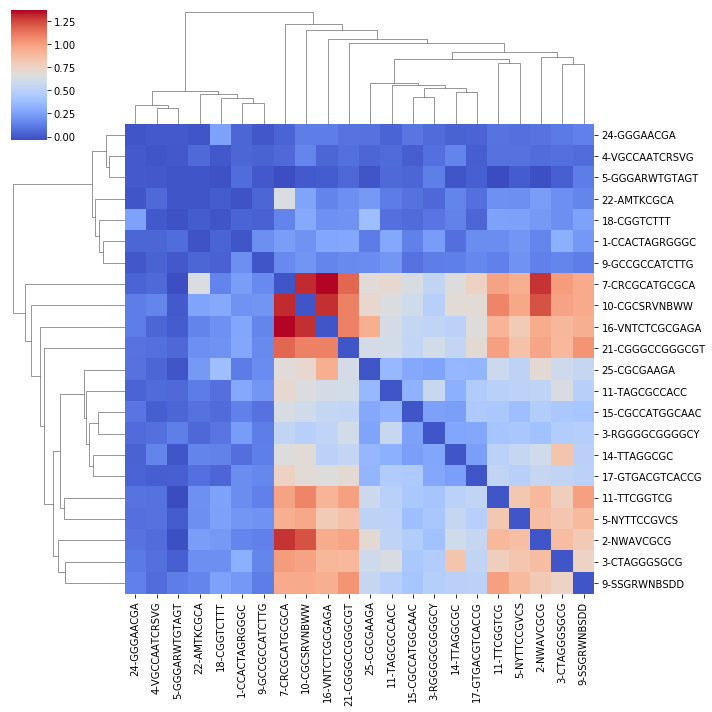

In [8]:
import seaborn
seaborn.clustermap(cooc_matrix, cmap="coolwarm", xticklabels=motif_names, yticklabels=motif_names)